In [94]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

Getting data.

In [95]:
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info)

tfds.core.DatasetInfo(
    name='iris',
    version=2.0.0,
    description='This is perhaps the best known database to be found in the pattern recognition
literature. Fisher's paper is a classic in the field and is referenced
frequently to this day. (See Duda & Hart, for example.) The data set contains
3 classes of 50 instances each, where each class refers to a type of iris
plant. One class is linearly separable from the other 2; the latter are NOT
linearly separable from each other.
',
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=150,
    splits={
        'train': 150,
    },
    supervised_keys=('features', 'label'),
    citation="""@misc{Dua:2019 ,
    author = "Dua, Dheeru and Graff, Casey",
    year = "2017",
    title = "{UCI} Machine Learning Repository",
    url = "http://archi

Splitting training and test sets.

In [96]:
ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)
ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

Transforming the dataset into tuples



In [97]:
ds_train_orig = ds_train_orig.map(
                lambda x: (x['features'], x['label']))
ds_test = ds_test.map(lambda x: (x['features'], x['label']))


Creating training models

In [98]:
iris_model = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='sigmoid', name='fcl', input_shape=(4,)),
            tf.keras.layers.Dense(3, name='fc2', activation='softmax')
])
iris_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fcl (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [99]:
iris_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [100]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)

history = iris_model.fit(ds_train, epochs=num_epochs, steps_per_epoch=steps_per_epoch, verbose=0)

Plotting the training loss and accuracy.

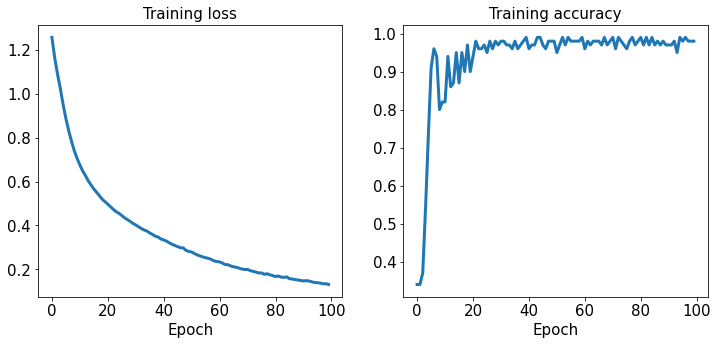

In [101]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Evaluating the trained model on the test set.

In [102]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))


Test loss: 0.1329   Test Acc.: 0.9800


Saving the trained model

In [103]:
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

Reloading the saved model

In [104]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fcl (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Testing the reloaded model on the training set.
Error rate is higher on the reloaded model. Unsure why.

In [105]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1329   Test Acc.: 0.3400


In [106]:
labels_train = []
for i,item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i,item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))



Training Set:  100 Test Set:  50
